In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import random
import numpy as np
from seirsplus.networks import generate_demographic_contact_network, household_country_data
from seirsplus.viral_model import ViralExtSEIRNetworkModel
from seirsplus.sim_loops_pooled_test import SimulationRunner

## Note: these are results of sensitivity analyses started 6/8/2023 night, using parameter values in `test_0608.yaml`. We were varying pool size and LoD with baseline pool size 10 and baseline LoD 174.

In [3]:
import pickle

NUM_TRIALS = 20


param_config = {
    "pop_size_default": 10000,

    "init_prev_default": 0.01,

    'horizon_default': 100,

    "num_groups_default": 10,

    'pool_size': [30, 40, 50, 60],
    'pool_size_default': 10,

    'LoD': [174, 500, 800],
    'LoD_default': 174,

    "beta_default": 0.5, # transmissibility
    "sigma_default": 0.2, # rate E --> I_pre
    "lamda_default": 0.5, # rate I_pre --> I_(a)sym
    "gamma_default": 0.25 # rate I_sym --> R
}


# Vary LoD

In [4]:

paths = {}

param_to_vary = "LoD"


for param_val in param_config[param_to_vary]:
    # path = "../results/US"
    path = "/home/yz685/corr_pooling_seirsplus/results/US"

    for param_name in [
        "pop_size", "init_prev", "num_groups", "pool_size", "horizon", 
        "beta", "sigma", "lamda", "gamma", "LoD"
    ]:
            
        if param_name == param_to_vary:
            path += f"_{param_name}={param_val}"
        else:
            path += f"_{param_name}={param_config[param_name+'_default']}"
        
    paths[param_val] = path



In [5]:
paths

{174: '/home/yz685/corr_pooling_seirsplus/results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=174',
 500: '/home/yz685/corr_pooling_seirsplus/results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=500',
 800: '/home/yz685/corr_pooling_seirsplus/results/US_pop_size=10000_init_prev=0.01_num_groups=10_pool_size=10_horizon=100_beta=0.5_sigma=0.2_lamda=0.5_gamma=0.25_LoD=800'}

In [6]:
from collections import defaultdict
def defaultdict_list():
    return defaultdict(list)

results = defaultdict(defaultdict_list) # dict of dict of list of individual results

for param_val, path in paths.items():
    for pooling_strategy in ["naive", "correlated"]:
        for i in range(NUM_TRIALS):
            filepath = path + f"/{pooling_strategy}/results_{i}.pickle"
            try:
                with open(filepath, "rb") as f:
                    results[pooling_strategy][param_val].append(pickle.load(f))
            except Exception as e:
                print("error: ", e)
                continue


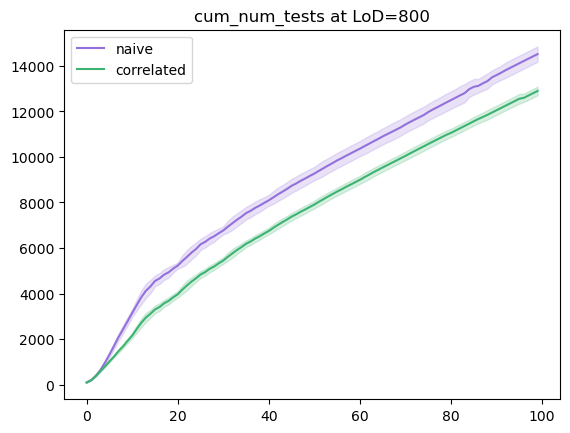

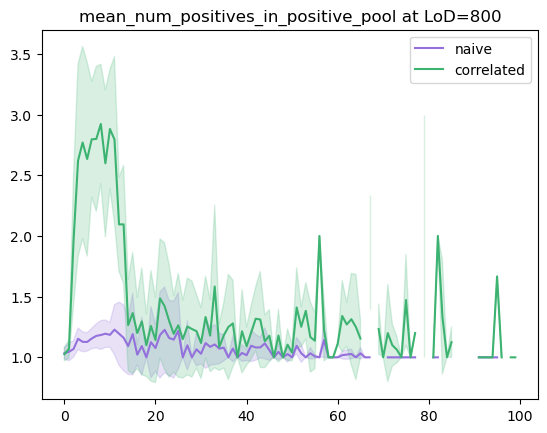

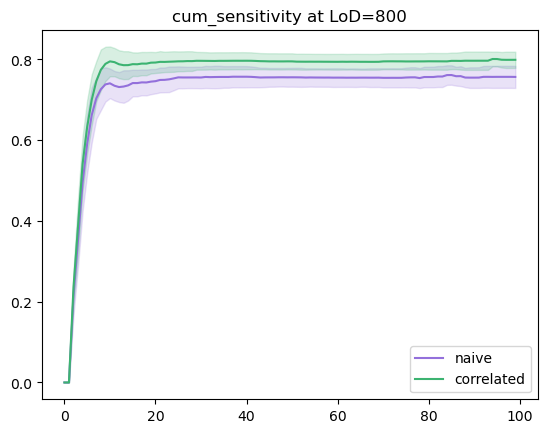

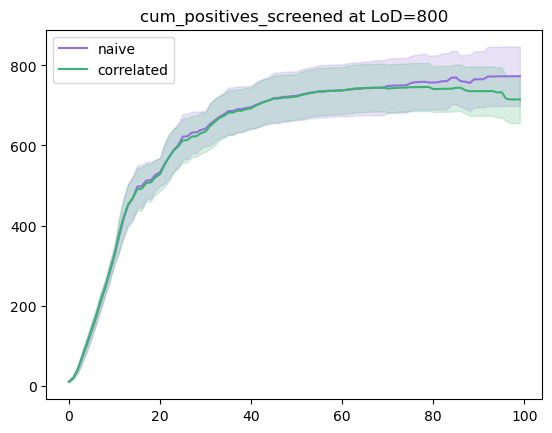

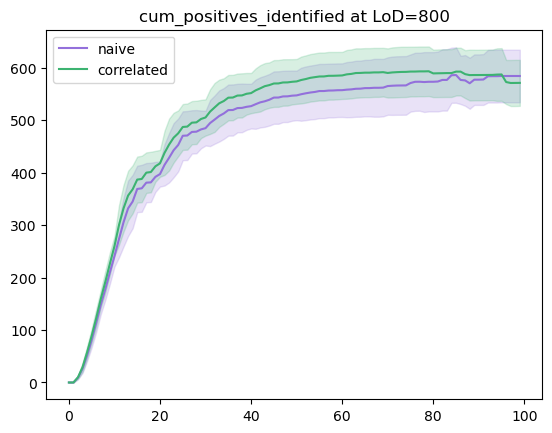

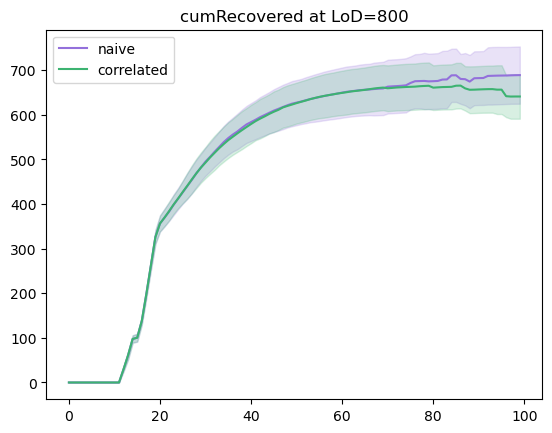

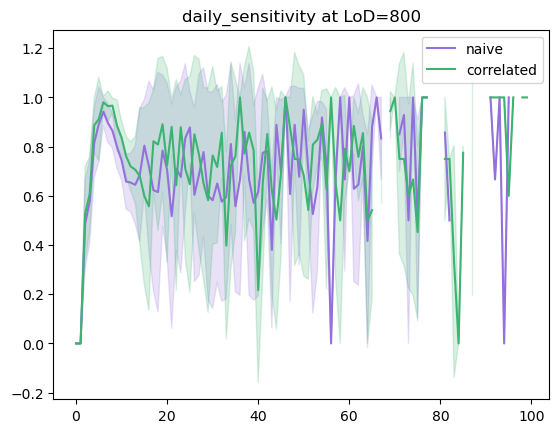

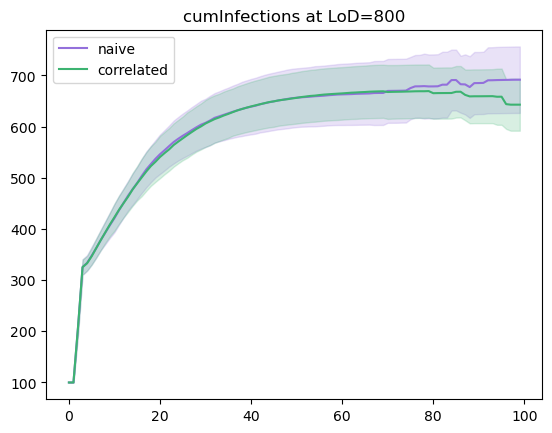

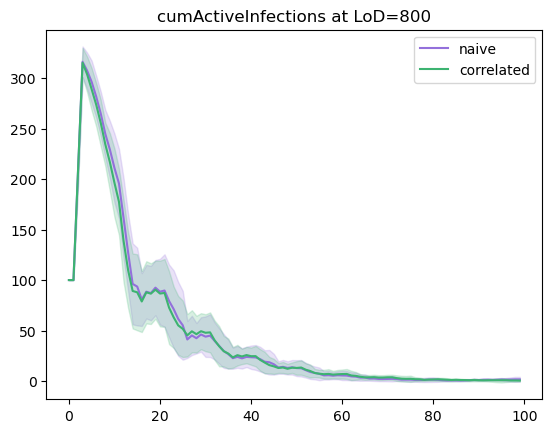

In [8]:
PARAM_VAL= 800
metrics = set(results["correlated"][PARAM_VAL][0][0].keys()) - set(["day"])

for metric in metrics:

    naive_results = []
    correlated_results = []

    for SEED in range(20):

        naive_results.append(
            [x[metric]\
            for x in results["naive"][PARAM_VAL][SEED]]
        )
        correlated_results.append(
            [x[metric]\
            for x in results["correlated"][PARAM_VAL][SEED]]
        )

    naive_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in naive_results], dtype=float)
    correlated_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in correlated_results][:100], dtype=float)

    naive_mean = np.nanmean(naive_results_, axis=0)
    naive_std = np.nanstd(naive_results_, axis=0)
    correlated_mean = np.nanmean(correlated_results_, axis=0)
    correlated_std = np.nanstd(correlated_results_, axis=0)

    plt.plot(naive_mean, color="mediumpurple", label="naive")
    plt.fill_between(
        range(len(naive_mean)),
        naive_mean-naive_std,
        naive_mean+naive_std,
        alpha=0.2,
        color="mediumpurple"
    )

    plt.plot(correlated_mean, color="mediumseagreen", label="correlated")
    plt.fill_between(
        range(len(correlated_mean)),
        correlated_mean-correlated_std,
        correlated_mean+correlated_std,
        alpha=0.2,
        color="mediumseagreen"
    )

    plt.title(f"{metric} at {param_to_vary}={PARAM_VAL}")
    plt.legend()
    plt.show()

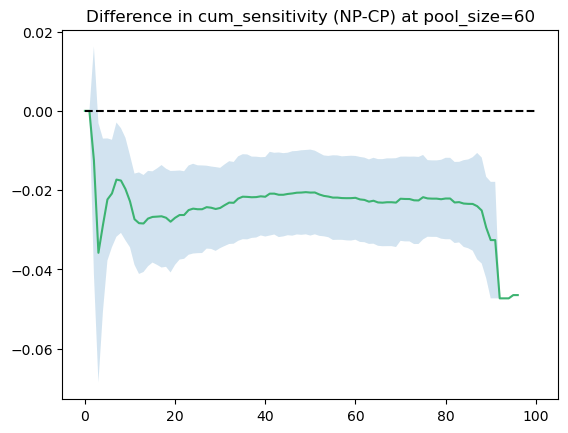

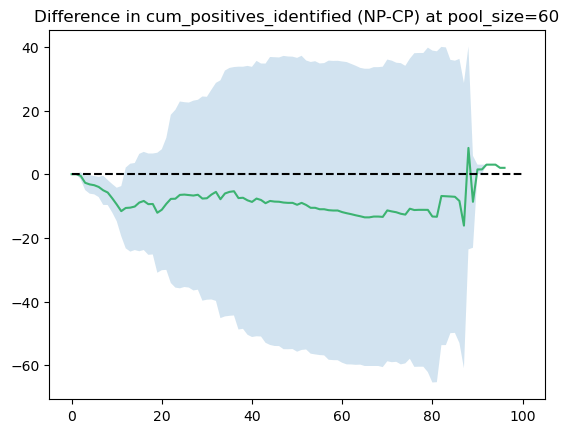

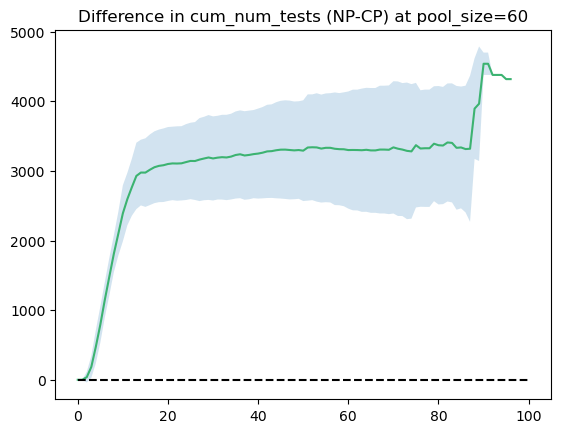

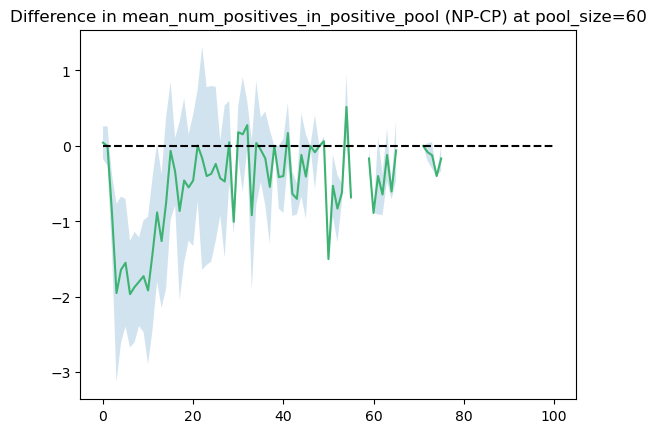

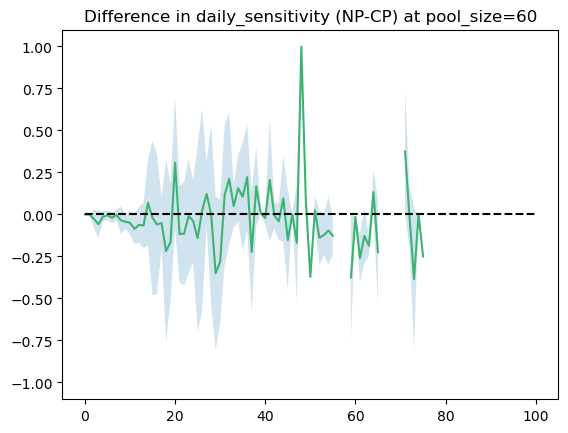

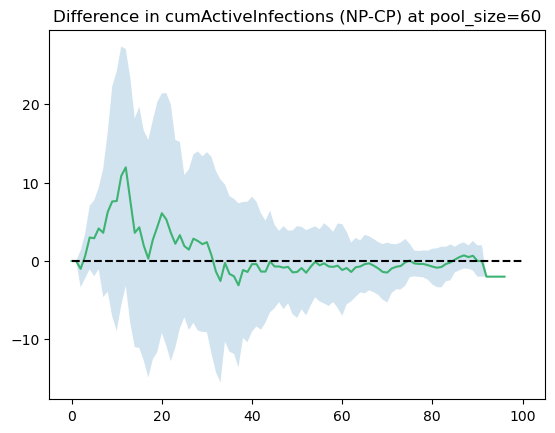

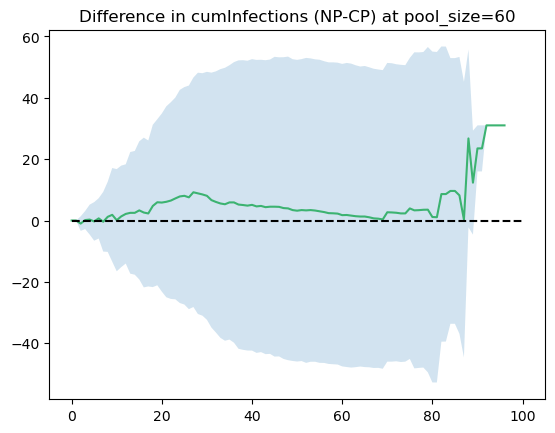

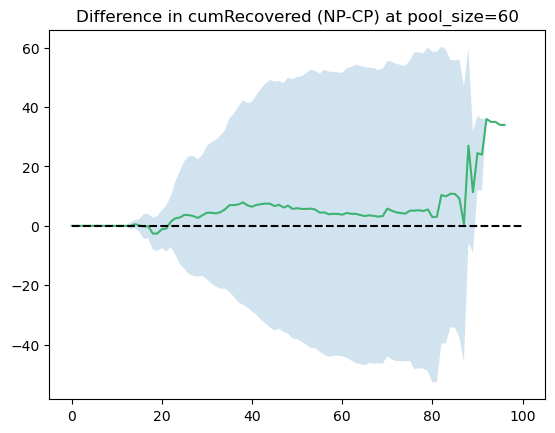

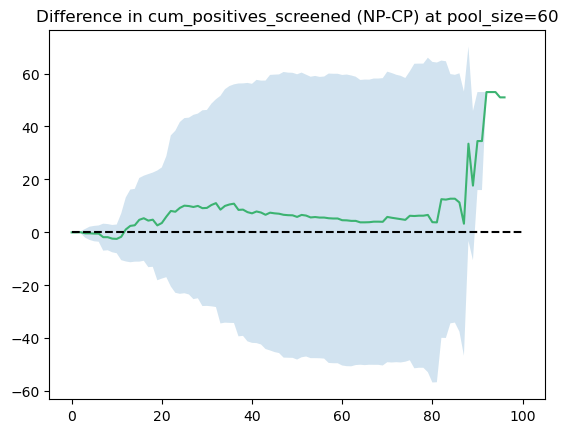

In [10]:
metrics = set(results["correlated"][PARAM_VAL][0][0].keys()) - set(["day"])

for metric in metrics:

    naive_results = []
    correlated_results = []

    # for SEED in range(5):
    for SEED in range(len(results["correlated"][PARAM_VAL])):

        naive_results.append(
            [x[metric]\
            for x in results["naive"][PARAM_VAL][SEED]]
        )
        correlated_results.append(
            [x[metric]\
            for x in results["correlated"][PARAM_VAL][SEED]]
        )

    naive_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in naive_results], dtype=float)
    correlated_results_ = np.array([(xi+[None]*(100-len(xi)))[:100] for xi in correlated_results][:100], dtype=float)

    diff = naive_results_ - correlated_results_
    diff_mean = np.nanmean(diff, axis=0)
    diff_std = np.nanstd(diff, axis=0)

    plt.plot(diff_mean, color="mediumseagreen")
    plt.fill_between(
        range(len(diff_mean)),
        diff_mean-diff_std,
        diff_mean+diff_std,
        alpha=0.2,
    )
    plt.hlines(0, 0, 100, color="black", linestyle="dashed")
    plt.title(f"Difference in {metric} (NP-CP) at {param_to_vary}={PARAM_VAL}")
    plt.show()

This seems to argue for increasing LoD, because increasing pool size alone is not enough. 